In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# State Data with fips state data for geolocation
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv'
df = pd.read_csv(url)
print(df.head(5))
print("Current date of dataset: ",df.iloc[-1,0])

         date  cases  deaths
0  2020-01-21      1       0
1  2020-01-22      1       0
2  2020-01-23      1       0
3  2020-01-24      2       0
4  2020-01-25      3       0
Current date of dataset:  2020-05-03


In [3]:
df = df.loc[:,['date','cases','deaths']]
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days  )

In [4]:
# Calculate the general percentage of infection by dividing the number of new cases
# by the average census and multiplying by 100.
# For more specific rates, divide the number of new cases by total resident days and multiply by 1000,
# which gives you the number of infections per 1000 resident days.

# US 2020 est. pop. 331,002,651
pop = 331002651
deaths = df.iloc[-1,2]
adj_pop = pop - deaths
Inf_rate = ((df.iloc[-1,1]/adj_pop)*1000)
current_cases = df.iloc[-1,1]
current_date = df.iloc[-1,0]
current_deaths = df.iloc[-1,2]
print("Current infection rate: ",Inf_rate)
print("Current cases: ", current_cases)
print("Current deaths: ",current_deaths)

Current infection rate:  3.5010975129605693
Current cases:  1158655
Current deaths:  62140


In [5]:
a = Inf_rate
b = df.iloc[-1,0] # Last Date
c = df.iloc[-1,1] # Last Cases count
d = df.iloc[-1,2] # Last Death count
x = list(df.iloc[:,0]) # dates
y = list(df.iloc[:,1]) # cases
z = list(df.iloc[:,2]) # deaths

In [6]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [7]:
def logistic_modelz(z,a,b,d):
    return d/(1+np.exp(-(z-b)/a))

In [8]:
# Cases
p0=[10,200,3000]
fit = curve_fit(logistic_model,x,y,p0)
fit

(array([8.29977128e+00, 1.04058485e+02, 1.21211935e+06]),
 array([[4.35244005e-02, 6.09658296e-02, 3.32889030e+03],
        [6.09658296e-02, 1.35996839e-01, 6.68399899e+03],
        [3.32889030e+03, 6.68399899e+03, 3.70242258e+08]]))

In [9]:
# Cases
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
print(errors)

[0.20862502377464054, 0.36877749203491944, 19241.68022247784]


In [10]:
# Deaths
p1=[10,200,3000]
fitz = curve_fit(logistic_model,x,z,p1)
fitz

(array([7.12588923e+00, 1.07631027e+02, 6.69533044e+04]),
 array([[1.93899791e-02, 2.85868848e-02, 1.01469968e+02],
        [2.85868848e-02, 6.47766187e-02, 2.10324388e+02],
        [1.01469968e+02, 2.10324388e+02, 7.58213811e+05]]))

In [11]:
# Deaths
errorsz = [np.sqrt(fitz[1][i][i]) for i in [0,1,2]]
print(errorsz)

[0.13924790524069183, 0.25451251187742363, 870.7547362482727]


In [12]:
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))

C:\Users\chukr\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [13]:
solz = int(fsolve(lambda x : logistic_modelz(x,a,b,d) - int(d),b))

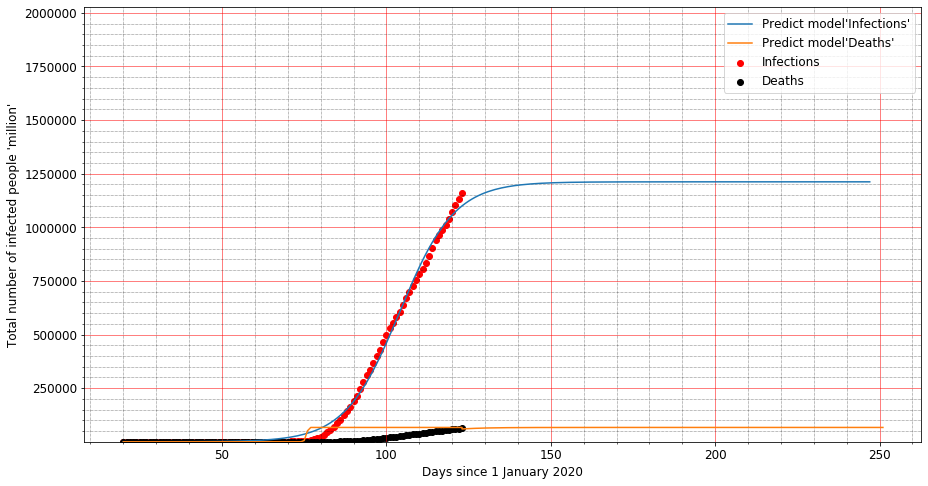

In [14]:
pred_x = list(range(max(x),sol)) # Dates
pred_z = list(range(max(x),solz)) # Dates
plt.rcParams['figure.figsize'] = [15, 8]

plt.rc('font', size=12, )

# Real data
plt.scatter(x,y,label="Infections",color="red")
# Real data
plt.scatter(x,z,label="Deaths",color="black")

# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Predict model'Infections'")

# Predicted logistic curve
plt.plot(x+pred_z, [logistic_modelz(i,fitz[0][0],fitz[0][1],fitz[0][2]) for i in z+pred_z], label="Predict model'Deaths'")

plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Total number of infected people 'million'")
plt.ylim((min(y)*2.5,c*1.75))

# plt.grid()

# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()

# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')